In [1]:
NAME = "Michael Cornelisse"
STUDENT_NUMBER = "s1059020"
COLLABORATOR_NAME = "Nienke Helmers"
COLLABORATOR_STUDENT_NUMBER = "s1016904"

In [2]:
# import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from graphviz import Source
import xgboost as xgb

In [3]:
PROJECT_ROOT_DIR = "."

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", fig_id)

In [4]:
# Load data
#actual_data = pd.read_csv('data/archive/actual.csv')
patient_data = pd.read_csv('data/archive/actual.csv', index_col = 'patient')
train_data = pd.read_csv('data/archive/data_set_ALL_AML_train.csv')
test_data = pd.read_csv('data/archive/data_set_ALL_AML_independent.csv')

In [5]:
# Clean all the data
# Drop the call collumns from both data sets
call_cols_train = [col for col in train_data.columns if 'call' in col]
train_data = train_data.drop(call_cols_train, axis = 1)

call_cols_test = [col for col in test_data.columns if 'call' in col]
test_data = test_data.drop(call_cols_test, axis = 1)

# Drop "Gene Description" and "Gene Accession Number"
cols_to_drop = ['Gene Description', 'Gene Accession Number']
train_data = train_data.drop(cols_to_drop, axis = 1)
test_data = test_data.drop(cols_to_drop, axis = 1)

# Transpose both data_sets
train_data = train_data.T
test_data = test_data.T

# now clean the patient_data
patient_data = patient_data.replace({'ALL': 0, 'AML': 1})
patient_train = patient_data[patient_data.index <= 38]
patient_test = patient_data[patient_data.index > 38]

# Define labels to use in our decission tree later.
patient_labels = ['ALL', 'AML']

# Make a seperate numpy array with our patient data, patient train data and patient test data
patient_data_np = patient_data.to_numpy()
patient_train_np = patient_train.to_numpy()
print(patient_data_np.shape)


(72, 1)


In [6]:
# Show head patient data 0 = ALL, 1 = AML
patient_data.head()

,cancer
patient,
1,0
2,0
3,0
4,0
5,0


In [30]:
# Merge the test and training data set together
train_data = train_data.reset_index(drop=True)
patient_train = patient_train.reset_index(drop=True) 
test_data = test_data.reset_index(drop=True)
patient_test= patient_test.reset_index(drop=True)

train_data = train_data.replace(np.inf, np.nan)
train_data = train_data.fillna(value = train_data.values.mean())

test_data = test_data.replace(np.inf, np.nan)
test_data = test_data.fillna(value = train_data.values.mean())

complete_data = train_data.append(test_data) # or train_data.append(test_data, ignore_index = True)
complete_data= complete_data.reset_index(drop=True)

complete_data

,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
0,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
1,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
2,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
3,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
4,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,-62,-198,-5,141,-256,-206,-298,-218,-14,100,...,92,532,-34,239,-78,707,354,-22,260,5
68,-58,-217,63,95,-191,-230,-86,-152,-6,-249,...,63,297,36,358,2,423,41,0,1777,-49
69,-161,-215,-46,146,-172,-596,-122,-341,171,-147,...,130,639,-27,548,-39,809,445,-2,210,16
70,-48,-531,-124,431,-496,-696,-1038,-441,235,157,...,84,1141,-121,197,-108,466,349,0,284,-73


In [31]:
# Dimensionality reduction PCA
pca = PCA()
pca_data = pca.fit_transform(complete_data)

pca_variance_ratio = pca.explained_variance_ratio_.cumsum()
pca_variance_percentage = pca_variance_ratio*100

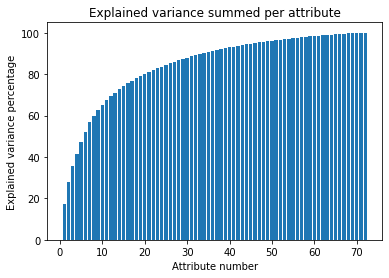

Figure: A plot of the explained variance. The variance is summed for all attributes up to and including
the current attribute number,for examplethe tenth attribute shows the sum of attributes 1 to 10.
There are 33 attributes that together explain 90% of the variance.


In [32]:
#Calculate and plot explained variance PCA
pca_variance_ratio = pca.explained_variance_ratio_.cumsum()
pca_variance_percentage = pca_variance_ratio * 100
plt.bar(range(1,pca_variance_percentage.size+1), pca_variance_percentage)
plt.title("Explained variance summed per attribute")
plt.xlabel("Attribute number")
plt.ylabel("Explained variance percentage")
plt.show()
print('''Figure: A plot of the explained variance. The variance is summed for all attributes up to and including
the current attribute number,for examplethe tenth attribute shows the sum of attributes 1 to 10.''')

#Determine number of attributes needed for an explained variance of 90%
pca_variance_cropped = [i for i in pca_variance_percentage if i <= 90]
no_attributes = len(pca_variance_cropped)
print("There are {} attributes that together explain 90% of the variance." .format(no_attributes))

In [38]:
#Crop pca_data
pca_data = np.delete(pca_data, slice(no_attributes, len(pca_data)) , 1)

#Split data back to original train and test split
pca_train = pca_data[:38]
pca_test = pca_data[38:]

print(pca_train.shape)

(38, 33)


In [34]:
def plot_classification_error(start, stop, step, accuracy_mean_train, accuracy_mean_test, function):
    plt.plot(range(start,stop, step), (1-accuracy_mean_train), label='accuracy train set')
    plt.plot(range(start,stop, step), (1-accuracy_mean_test), label='accuracy test set')
    plt.legend()
    plt.xlabel('Maximum {}'.format(function))
    plt.ylabel('Classification error')
    plt.title('Classification error of a decision tree as function of {}'.format(function))
    plt.show()

def k_fold(folds, start, stop, step, method, function):
    kf = KFold(n_splits=folds)
    accuracy_mean_train = np.array([])
    accuracy_mean_test = np.array([])
    for i in range(start, stop, step):
        accuracy_train = np.array([])
        accuracy_test = np.array([])
        for train, test in kf.split(pca_data, patient_data):
            
            if(method == 'tree'):
                split_clf = tree.DecisionTreeClassifier(criterion='gini', max_depth = i)
                split_clf = split_clf.fit(pca_data[train], patient_data_np[train])
                accuracy_train = np.append(
                    accuracy_train, metrics.accuracy_score(patient_data_np[train], split_clf.predict(pca_data[train])))
                accuracy_test = np.append(
                    accuracy_test, metrics.accuracy_score(patient_data_np[test], split_clf.predict(pca_data[test]))) 
            
            elif(method == 'rf'):
                rf = RandomForestClassifier(n_estimators = 100, criterion='gini', max_depth = i)
                rf = rf.fit(pca_data[train], patient_data_np[train])
                accuracy_train = np.append(
                    accuracy_train, metrics.accuracy_score(patient_data_np[train], rf.predict(pca_data[train])))
                accuracy_test = np.append(
                    accuracy_test, metrics.accuracy_score(patient_data_np[test], rf.predict(pca_data[test]))) 
                
            elif(method == 'rf_estimators'):
                rf = RandomForestClassifier(n_estimators = i, criterion='gini', max_depth = 4)
                rf = rf.fit(pca_data[train], patient_data_np[train])
                accuracy_train = np.append(
                    accuracy_train, metrics.accuracy_score(patient_data_np[train], rf.predict(pca_data[train])))
                accuracy_test = np.append(
                    accuracy_test, metrics.accuracy_score(patient_data_np[test], rf.predict(pca_data[test])))
                
            elif(method =='xgb'):
                rf = xgb.XGBClassifier(n_estimators = 100, max_depth = i, eval_metric='error', use_label_encoder=False)
                rf = rf.fit(pca_data[train], patient_data_np[train])
                accuracy_train = np.append(
                    accuracy_train, metrics.accuracy_score(patient_data_np[train], rf.predict(pca_data[train])))
                accuracy_test = np.append(
                    accuracy_test, metrics.accuracy_score(patient_data_np[test], rf.predict(pca_data[test]))) 
                
            elif(method == 'xgb_estimators'):
                rf = xgb.XGBClassifier(n_estimators = i, max_depth = 5, eval_metric='error', use_label_encoder=False)
                rf = rf.fit(pca_data[train], patient_data_np[train])
                accuracy_train = np.append (accuracy_train, metrics.accuracy_score(patient_data_np[train], rf.predict(pca_data[train])))
                accuracy_test = np.append(accuracy_test, metrics.accuracy_score(patient_data_np[test], rf.predict(pca_data[test]))) 
                
        accuracy_mean_train = np.append(accuracy_mean_train, np.mean(accuracy_train))
        accuracy_mean_test = np.append(accuracy_mean_test, np.mean(accuracy_test))
    plot_classification_error(start, stop, step, accuracy_mean_train, accuracy_mean_test, function)

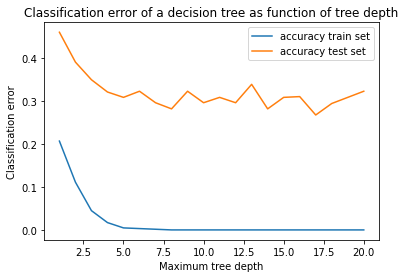

In [35]:
# Plot accuracy test and train
k_fold(10, 1, 21, 1, 'tree', 'tree depth')

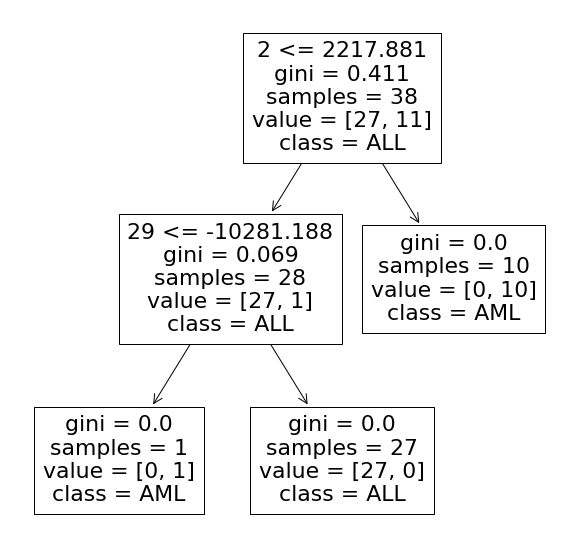

The standard decision tree has an accuracy of 0.5588235294117647 and an error rate of 0.4411764705882353.


In [36]:
# Fit the actual tree
# Fit the actual decision tree
# firstly we wil lfit the tree with the gini criterion
tree_clf = tree.DecisionTreeClassifier(criterion='gini', max_depth = 4)
tree_clf = tree_clf.fit(pca_train, patient_train)
plt.figure(figsize=(10, 10))
tree.plot_tree(tree_clf, feature_names = range(1,34), class_names = patient_labels)
plt.show()
accuracy = metrics.accuracy_score(patient_test, tree_clf.predict(pca_test))
print("The standard decision tree has an accuracy of {} and an error rate of {}.".format(accuracy, 1-accuracy))

In [16]:
def plot_tree_with_file(inp, path, start, stop):
    dot_data = export_graphviz(
        inp,
        out_file = image_path(path),#os.path.join(image_path, "tree.dot") ,
        feature_names = range(1,34),
        class_names = patient_labels,
        rounded=True,
        filled=True
    )
    graph = Source.from_file("images/" + path)
    return graph

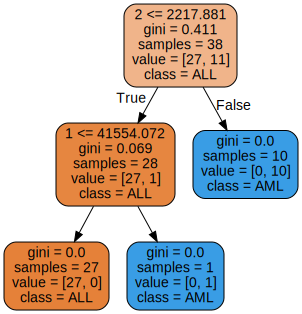

In [17]:
graph_gini = plot_tree_with_file(tree_clf,'decision_tree_gini.dot', 1, 34)
graph_gini

In [18]:
def plot_tree_graph(inp, start, stop):
    dot_data = export_graphviz(inp, out_file=None, 
                               feature_names=range(1,34),  
                               class_names=patient_labels,
                               rounded=True,
                               filled=True)
    # Draw graph
    graph = Source(dot_data, format="png") 
    return graph

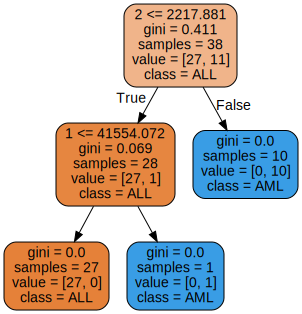

In [19]:
# Now we will show the decision tree with gini criterion 
graph = plot_tree_graph(tree_clf, 1, 34)
graph

In [20]:
accuracy = metrics.accuracy_score(patient_test, tree_clf.predict(pca_test))
print("The standard decision tree with gini has an accuracy of {} and an error rate of {}.".format(accuracy, 1-accuracy))

The standard decision tree with gini has an accuracy of 0.5294117647058824 and an error rate of 0.47058823529411764.


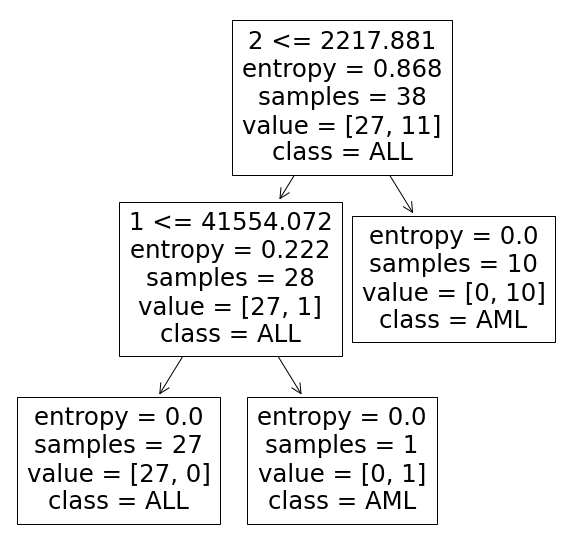

The standard decision tree with entropy has an accuracy of 0.5294117647058824 and an error rate of 0.47058823529411764.


In [21]:
# fit decision tree with entropy criterion
tree_clf_ent = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 4)
tree_clf_ent = tree_clf_ent.fit(pca_train, patient_train)
plt.figure(figsize=(10, 10))
tree.plot_tree(tree_clf_ent, feature_names = range(1,34), class_names = patient_labels)
plt.show()
accuracy = metrics.accuracy_score(patient_test, tree_clf_ent.predict(pca_test))
print("The standard decision tree with entropy has an accuracy of {} and an error rate of {}.".format(accuracy, 1-accuracy))

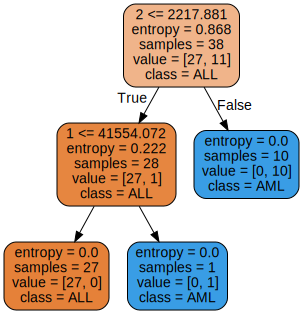

In [22]:
graph_entrophy = plot_tree_with_file(tree_clf_ent,'decision_tree_entropy.dot', 1, 34)

graph_entrophy

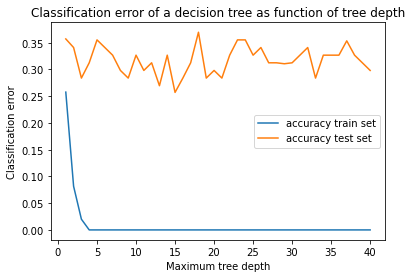

In [23]:
# Classification Random Forrest
patient_train_np = patient_train_np.ravel()

rf = RandomForestClassifier(n_estimators = 10, criterion='gini', max_depth = 10)
rf.fit(pca_train, patient_train_np)

accuracy = metrics.accuracy_score(patient_test, rf.predict(pca_test))
error = 1-accuracy

accuracy_mean_train = np.array([])
accuracy_mean_test = np.array([])

patient_data_np = patient_data_np.ravel()

# Plot accuracy test and train for tree depth
k_fold(10, 1, 41, 1, 'rf', 'tree depth')

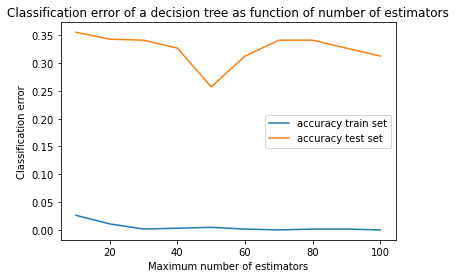

In [24]:
#Plot accuracy test and train for number of estimators
k_fold(10, 10, 101, 10, 'rf_estimators', 'number of estimators')

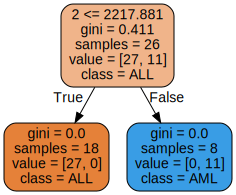

In [25]:
#visualisation random forest classifier
rf = RandomForestClassifier(n_estimators = 1000, criterion='gini', max_depth = 4)
rf = rf.fit(pca_train, patient_train_np)

estimator = rf.estimators_[100]

graph_rf = plot_tree_with_file(estimator,'random_forest.dot', 1, 34)

graph_rf


In [26]:
# Use the forest's predict method on the test data
accuracy = metrics.accuracy_score(patient_test, rf.predict(pca_test))
print("The Random forrest has an accuracy of {} and an error rate of {}.".format(accuracy, 1-accuracy))

The Random forrest has an accuracy of 0.6176470588235294 and an error rate of 0.38235294117647056.


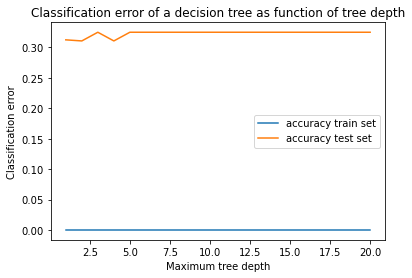

In [27]:
# Classification Gradient Boost
# https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters
k_fold(10, 1, 21, 1, 'xgb', 'tree depth')

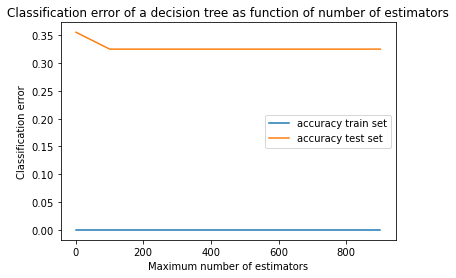

In [28]:
kf = KFold(n_splits=10)
accuracy_mean_train = np.array([])
accuracy_mean_test = np.array([])
for i in range(10, 1001, 100):
    accuracy_train = np.array([])
    accuracy_test = np.array([])
    for train, test in kf.split(pca_data, patient_data):
        rf = xgb.XGBClassifier(n_estimators = i, max_depth = 5, eval_metric='error', use_label_encoder=False)
        rf = rf.fit(pca_data[train], patient_data_np[train])
        accuracy_train = np.append (accuracy_train, metrics.accuracy_score(patient_data_np[train], rf.predict(pca_data[train])))
        accuracy_test = np.append(accuracy_test, metrics.accuracy_score(patient_data_np[test], rf.predict(pca_data[test]))) 
                
    accuracy_mean_train = np.append(accuracy_mean_train, np.mean(accuracy_train))
    accuracy_mean_test = np.append(accuracy_mean_test, np.mean(accuracy_test))
plot_classification_error(1, 1001, 100, accuracy_mean_train, accuracy_mean_test, 'number of estimators')

#k_fold(10, 1, 1001,100, 'xgb_estimator', 'number of estimators' )

In [29]:
rf = xgb.XGBClassifier(n_estimators = 50, max_depth = 5, eval_metric='error')
rf = rf.fit(pca_train, patient_train_np)

estimator = rf.get_booster().get_dump()

estimator = xgb.save(rf, 'boost_tree.dot')

graph_rf = plot_tree_with_file(estimator,'random_forest.dot', 1, 34)

graph_rf
#print (estimator)

xgb.to_graphviz(rf, num_trees=0)

D:\Programmes\Anaconda\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


AttributeError: module 'xgboost' has no attribute 'save'